<a href="https://colab.research.google.com/github/ukhyun-lee/stock_market_analysis/blob/main/AI%EC%A4%91%EA%B8%89/AI%EC%8B%A4%EC%8A%B5_8%EC%9B%9425%EC%9D%BC(GRU).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(125)

In [2]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1.0,))
])
from torchvision.datasets import MNIST
#download_root = 'MNIST_DATASET/'
download_root = 'sample_data/MNIST_DATASET/'

train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
valid_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 75054267.86it/s]


Extracting sample_data/MNIST_DATASET/MNIST/raw/train-images-idx3-ubyte.gz to sample_data/MNIST_DATASET/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 31877814.16it/s]


Extracting sample_data/MNIST_DATASET/MNIST/raw/train-labels-idx1-ubyte.gz to sample_data/MNIST_DATASET/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25078021.56it/s]


Extracting sample_data/MNIST_DATASET/MNIST/raw/t10k-images-idx3-ubyte.gz to sample_data/MNIST_DATASET/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5588304.13it/s]


Extracting sample_data/MNIST_DATASET/MNIST/raw/t10k-labels-idx1-ubyte.gz to sample_data/MNIST_DATASET/MNIST/raw



In [4]:
batch_size = 64
train_loader = DataLoader(dataset=train_dataset,
                         batch_size=batch_size,
                         shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset,
                         batch_size=batch_size,
                         shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True)
batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

In [7]:
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 3 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 3 * hidden_size, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, hidden):
        x = x.view(-1, x.size(1))

        gate_x = self.x2h(x)
        gate_h = self.h2h(hidden)

        gate_x = gate_x.squeeze()
        gate_h = gate_h.squeeze()

        i_r, i_i, i_n = gate_x.chunk(3, 1)
        h_r, h_i, h_n = gate_h.chunk(3, 1)

        resetgate = F.sigmoid(i_r + h_r)
        inputgate = F.sigmoid(i_i + h_i)
        newgate = F.tanh(i_n + (resetgate * h_n))

        hy = newgate + inputgate * (hidden - newgate)
        return hy

In [8]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.gru_cell = GRUCell(input_dim, hidden_dim, layer_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
        else:
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

        outs = []
        hn = h0[0,:,:]

        for seq in range(x.size(1)):
            hn = self.gru_cell(x[:,seq,:], hn)
            outs.append(hn)

        out = outs[-1].squeeze()
        out = self.fc(out)
        return out
input_dim = 28
hidden_dim = 128
layer_dim = 1
output_dim = 10

model = GRUModel(input_dim, hidden_dim, layer_dim, output_dim)

if torch.cuda.is_available():
    model.cuda()

criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
seq_dim = 28
loss_list = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, seq_dim, input_dim))
            labels = Variable(labels)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        if torch.cuda.is_available():
            loss.cuda()

        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())
        iter += 1

        if iter % 500 == 0:
            correct = 0
            total = 0
            for images, labels in valid_loader:
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, seq_dim, input_dim).cuda())
                else:
                    images = Variable(images.view(-1 , seq_dim, input_dim))

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct / total
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 1.6616928577423096. Accuracy: 43.59000015258789
Iteration: 1000. Loss: 0.8945668935775757. Accuracy: 76.19999694824219
Iteration: 1500. Loss: 0.29147759079933167. Accuracy: 89.7300033569336
Iteration: 2000. Loss: 0.23627907037734985. Accuracy: 93.51000213623047
Iteration: 2500. Loss: 0.03288722783327103. Accuracy: 95.05000305175781
Iteration: 3000. Loss: 0.030374936759471893. Accuracy: 95.81999969482422
Iteration: 3500. Loss: 0.1621057391166687. Accuracy: 96.33999633789062
Iteration: 4000. Loss: 0.19308771193027496. Accuracy: 96.19000244140625
Iteration: 4500. Loss: 0.05172014236450195. Accuracy: 97.0
Iteration: 5000. Loss: 0.13900171220302582. Accuracy: 97.26000213623047
Iteration: 5500. Loss: 0.08090294897556305. Accuracy: 97.62000274658203
Iteration: 6000. Loss: 0.10488354414701462. Accuracy: 97.69000244140625
Iteration: 6500. Loss: 0.07984036952257156. Accuracy: 97.80000305175781
Iteration: 7000. Loss: 0.10250388830900192. Accuracy: 97.55999755859375
Iteration

In [11]:
def evaluate(model, val_iter):
    corrects, total, total_loss = 0, 0, 0
    model.eval()
    for images, labels in val_iter:
        if torch.cuda.is_available():
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
        else:
            images = Variable(images.view(-1 , seq_dim, input_dim)).to(device)
        #labels = labels.cuda()
        #logit = model(images).cuda()
        labels = labels
        logit = model(images)
        loss = F.cross_entropy(logit, labels, reduction = "sum")
        _, predicted = torch.max(logit.data, 1)
        total += labels.size(0)
        total_loss += loss.item()
        corrects += (predicted == labels).sum()

    avg_loss = total_loss / len(val_iter.dataset)
    avg_accuracy = corrects / total
    return avg_loss, avg_accuracy
test_loss, test_acc = evaluate(model,test_loader)
print("Test Loss: %5.2f | Test Accuracy: %5.2f" % (test_loss, test_acc))

Test Loss:  0.07 | Test Accuracy:  0.98


#GRU계층

In [12]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
data=pd.read_csv('sample_data/SBUX.csv')
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [13]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data['Volume'] = data['Volume'].astype(float)
X=data.iloc[:,:-1]
y=data.iloc[:,5:6]
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

In [14]:
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)
Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


In [15]:
class GRU(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(GRU, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        self.fc_1 =  nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        output, (hn) = self.gru(x, (h_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

Epoch: 0, loss: 0.09458
Epoch: 100, loss: 0.04280
Epoch: 200, loss: 0.03771
Epoch: 300, loss: 0.03502
Epoch: 400, loss: 0.03373
Epoch: 500, loss: 0.03336
Epoch: 600, loss: 0.03324
Epoch: 700, loss: 0.03316
Epoch: 800, loss: 0.03309
Epoch: 900, loss: 0.03302
Epoch: 1000, loss: 0.03295
Epoch: 1100, loss: 0.03289
Epoch: 1200, loss: 0.03284
Epoch: 1300, loss: 0.03279
Epoch: 1400, loss: 0.03274
Epoch: 1500, loss: 0.03269
Epoch: 1600, loss: 0.03264
Epoch: 1700, loss: 0.03258
Epoch: 1800, loss: 0.03253
Epoch: 1900, loss: 0.03249
Epoch: 2000, loss: 0.03244
Epoch: 2100, loss: 0.03239
Epoch: 2200, loss: 0.03235
Epoch: 2300, loss: 0.03231
Epoch: 2400, loss: 0.03228
Epoch: 2500, loss: 0.03226
Epoch: 2600, loss: 0.03224
Epoch: 2700, loss: 0.03222
Epoch: 2800, loss: 0.03220
Epoch: 2900, loss: 0.03218
Epoch: 3000, loss: 0.03216
Epoch: 3100, loss: 0.03214
Epoch: 3200, loss: 0.03212
Epoch: 3300, loss: 0.03210
Epoch: 3400, loss: 0.03208
Epoch: 3500, loss: 0.03206
Epoch: 3600, loss: 0.03204
Epoch: 3700, 

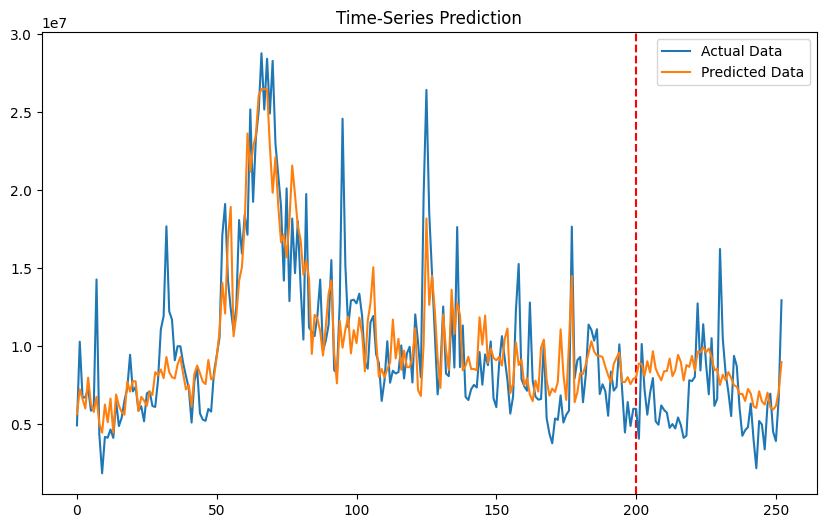

In [17]:
num_epochs = 10000
learning_rate = 0.0001

input_size = 5
hidden_size = 2
num_layers = 1

num_classes = 1
model = GRU(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()